# TME 1 - Explication par génération d'exemples contre-factuels

Travail réalisé par :    


*   BENHADDAD Sabrina
*   BENSIDHOUM Azzedine



In [2]:
#Importation des bibliothèques requises
from typing import List
import numpy as np

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn import tree
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')


<ipython-input-2-07ad632bbf95>:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## 1. Données

Implémentation d'une fonction génèrant une base de données synthétique de type **halfMoons**

In [3]:
def halfMoons(n: int, noises: List[float], nb_lines: int, nb_columns: int):

  """Fonction qui permet de générer et de visualiser les données de type halfMoons
  pour des niveaux de bruit différents
  n : le nombre de points à générer
  noises : une liste de bruits
  nb_lines, nb_columns : paramètres facilitant l'affichage des données
  """

  plt.figure(figsize=(5 * nb_columns, 5 * nb_lines)) #Pour afficher en une seule fois les données
  X = []
  Y = []
  for i, noise in enumerate(noises):
    plt.subplot(nb_lines, nb_columns, i+1)
    plt.title(f"Données de type Halfmoons pour un bruit {noise}")
    x, y = make_moons(n_samples=n, noise = noise)
    X.append(x)
    Y.append(y)
    plt.scatter(x[:, 0], x[:,1], c=y, cmap=plt.cm.Paired)
  plt.axis()


  return X,Y


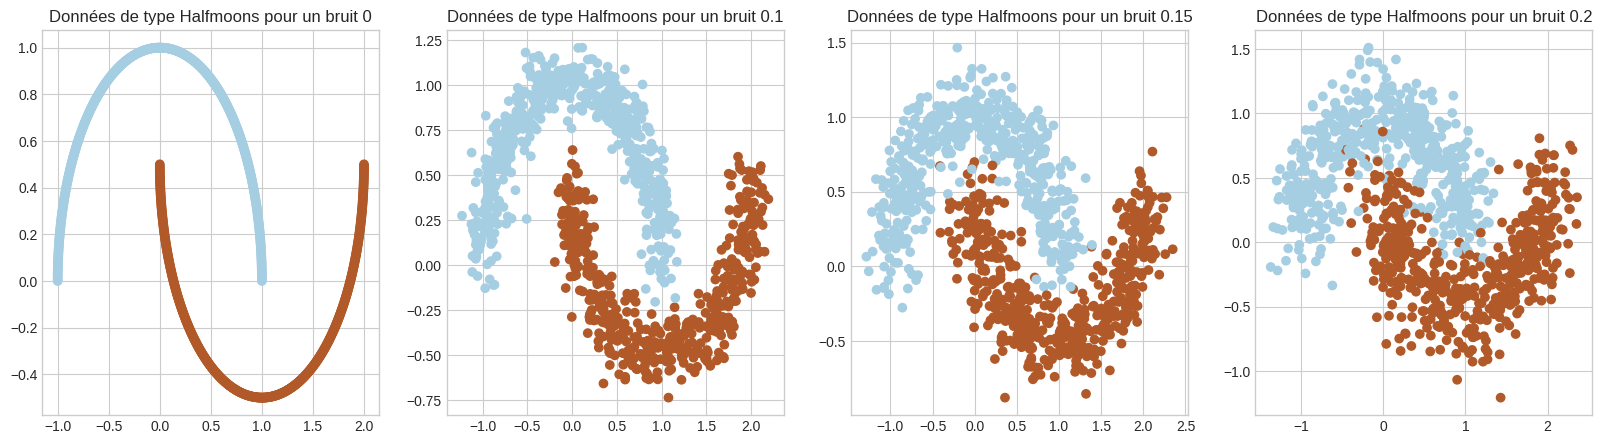

In [78]:
#Test de la fonction
n = 1000
noises = [0 , 0.1, 0.15, 0.2]
X,Y = halfMoons(n, noises,1,len(noises))

In [79]:
X_0,Y_0 = X[0],Y[0] #Correspondant à un bruit nul
X_1,Y_1 = X[1],Y[1] #Correspondant à un bruit de 0.1
X_2,Y_2 = X[2],Y[2] #Correspondant à un bruit de 0.15
X_3,Y_3 = X[3],Y[3] #Correspondant à un bruit de 0.2

In [80]:
X_0.shape, Y_0.shape

((1000, 2), (1000,))

## 2. Classifieurs
Implémentation des classifieurs KNN, SVM et Random Forest pour leur entraînement sur un ensemble de données d'apprentissage composé d'un sous-ensemble des données générées précédemment.

In [81]:
#Constituer notre base d'apprentissage (nous avons choisi les données ayant un bruit de 0.15)
X_train, X_test, Y_train, Y_test = train_test_split(X_2,Y_2, test_size = 0.3, random_state=42)

In [82]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((700, 2), (300, 2), (700,), (300,))

### KNN

In [83]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, Y_train)
y_neigh = neigh.predict(X_test)
print("Précision du modèle KNN : {:.2f}%".format(accuracy_score(Y_test, y_neigh) * 100))

Précision du modèle KNN : 97.33%


### SVM


In [84]:
clf = SVC(kernel='rbf', C=1.0)
clf.fit(X_train, Y_train)
y_svm = clf.predict(X_test)
print("Précision du modèle SVM : {:.2f}%".format(accuracy_score(Y_test, y_svm) * 100))

Précision du modèle SVM : 97.67%


### Random Forest

In [85]:
forest = RandomForestClassifier(max_depth = 2, random_state = 0)
forest.fit(X_train, Y_train)
y_forest = forest.predict(X_test)
print("Précision du modèle Random Forest : {:.2f}%".format(accuracy_score(Y_test, y_forest) * 100))

Précision du modèle Random Forest : 88.67%


## 3. Génération d'exemples contrefactuels
Implémentation de l'algorithme Growing Spheres



###1.   Implémentation de SL : génération de la couche sphérique



In [4]:
def SL(x,a_0,a_1,n):
  """
  Cette fonction permet de générer des points de la couche sphérique
  selon une distribution uniforme (algorithme donné en TME), tel que :
  x -  le centre de la sphère
  a_0 : int - le rayon interne
  a_1 : int - le rayon externe
  """
  #Ajustement et récupération des dimensions
  x = x.reshape(1,-1)
  d = x.shape[1]
  #Génération de la matrice Z (n,d) : n points dans la sphère de centre 0 et de rayon 1
  z = np.random.normal(0,1,size = (n,d))
  #Calcul de la norme de chaque vecteur z_i de la matrice z
  #L'objectif est que les points générés soient sur la sphère
  normes = np.linalg.norm(z, axis = 1, keepdims = True)
  #Normalisation de la matrice qui contient désormais les éléments normalisés
  z /= normes
  #Génération de n rayon de dimension (1,d) uniformément distribués
  u = (np.random.uniform((a_0**d),(a_1**d), size = (n,d)))**(1/d)

  return x + z * u


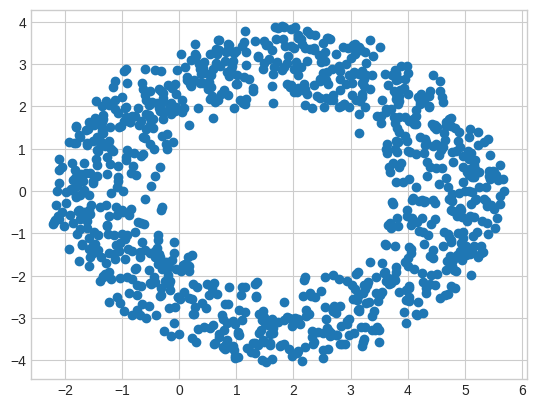

In [87]:
#Test de la fonction
z = SL(X_2[0],2,4,1000)
plt.scatter(z[:,0], z[:,1])

### 2. Algorithme Growing Spheres Generation
Pseudo-code donné en TME

In [5]:
import random
def GSGeneration(model, x, eta:float, n: int):
  """
  Fonction permettant de trouver le point le plus proche n'appartenant pas
  à la même classe que le point x : observation à interpréter et expliquer
  Paramètres:
   classifieur : un classifieur binaire
   x : donnée a expliquer
   eta : le rayon
   n : nombre de points à générer

  Returns:
    e : ennemi (point le plus proche appartenant à la classe inverse par rapport à x)

  """
  #Pour des soucis de dimension uniquement :
  if x.ndim != 2:
    x = x.reshape(1, -1)
  # Generation of z's in SL
  z = SL(x=x, a_0=0.0, a_1=eta, n=n)

  #Recherche du meilleur eta
  while np.any(model.predict(z) != model.predict(x.reshape(1,-1))):
    eta /= 2
    z = SL(x=x, a_0=0.0, a_1=eta, n=n)
  print("Meilleur eta trouvé : ",eta)

  a_0 = eta
  a_1 = 2 * eta

  #Recherche de l'ennemi e
  z = SL(x=x, a_0=a_0, a_1=a_1, n=n)
  # if we reach a good value for eta, we retrieve the closest point
  while not np.any(model.predict(z) != model.predict(x.reshape(1,-1))):
    z = SL(x=x, a_0=a_0, a_1=a_1, n=n)
    a_0 = a_1
    a_1 += eta

   #Return le L2 plus proche ennemi de x
  #On récupère les indices des points n'appartenant pas à la même classe que x
  indices = np.where(model.predict(z) != model.predict(x.reshape(1, -1)))[0]
  z = z[indices]
  e_idx = np.linalg.norm(x - z, axis=1, ord=2).argmin() # sortir tous ceux de la classe differente et prendre le plus proche de x

  return z[e_idx]


In [98]:
#Test de la fonction
np.random.seed(42)
clf = SVC(kernel='rbf', C=1.0).fit(X_train, Y_train)
x = X_2[100]
closest_e = GSGeneration(clf,x.reshape(1,-1),2,1000)
print(f"Le plus proche ennemi est : {closest_e}")


Meilleur eta trouvé :  0.5
Le plus proche ennemi est : [-0.48520307  0.1093446 ]


In [99]:
clf.predict(x.reshape(1,-1))

array([0])

In [100]:
clf.predict(closest_e.reshape(1,-1))

array([1])

Nous avons donc effectivement généré un ennemi (un point qui n'appartient pas à la même classe que le point x)

### 3. Algorithme Growing Spheres Feature Selection
Pseudo-code donné en TME

In [6]:
def GSFeatureSelection(classifieur, x, e):
  """
  Fonction permettant de trouver l'exemple contre-factuel

  Paramètres:
    classifieur : classifieur binaire
    x : observation à interpréter
    e : plus proche ennemi (solution de l'algorithme GSGeneration)

  Returns:
    e_star : l'exemple contre-factuel
  """
  e_prim = e.copy()
  i = 0
  j_s = [] # liste contenant les dimensions dejà sélectionnées
  while classifieur.predict(e_prim.reshape(1, -1)) != classifieur.predict(x.reshape(1,-1)):
    e_star = e_prim.copy()
    diff = np.abs(e_prim - x)
    diff[0,j_s] = np.inf # attribut une valeur très grand aux dimensions déjà modifiées
    j = diff.argmin()
    if(e_prim[j] != x.flatten()[j]):
      e_prim[j] = x.flatten()[j]
    j_s.append(j) # ajout de la dimension modifié à la liste

  return e_star


In [103]:
#Test de la fonction
e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)
print(f"Observation à interpréter {x} \nPlus proche ennemi issu de l'algorithme 1 {closest_e}\nExemple contre-factuel trouvé{e_opt}")

Observation à interpréter [-1.0487672   0.16212625] 
Plus proche ennemi issu de l'algorithme 1 [-0.48520307  0.1093446 ]
Exemple contre-factuel trouvé[-0.48520307  0.16212625]



## 4. Visualisation
Implémentation d'une fonction permettant de visualiser :

*   Les données
*   La frontière de décision
*   Une donnée à expliquer
*   L'exemple contre-factuel associé



In [104]:
def visualisation(classifieur,x, e_, e_opt,title):
  """
  Fonction permettant de visualiser les éléments mentionnés dans l'énoncé

  Paramètres :
   - Classifieur : le classifieur considéré
   - x : les données du modèle
   - y : les étiquettes
   - x_obs : la donnée à expliquer
   - e_ : l'ennemi de l'algorithme GSGeneration
   - e_opt : l'exemple contre-factuel
   """
  x_min, x_max = X_2[:, 0].min() - .5, X_2[:, 0].max() + .5
  y_min, y_max = X_2[:, 1].min() - .5, X_2[:, 1].max() + .5

  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

  Z = classifieur.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  plt.contourf(xx, yy, Z, alpha=.3,cmap="seismic")

  plt.title(title)

  plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', edgecolors='k', alpha=0.5, color=[['navy', 'darkred'][i] for i in Y_train])
  plt.scatter(x[0], x[1], marker='o', color='yellow', edgecolors='k', s=150,label="Observation")
  plt.scatter(e_[0], e_[1], marker='D', color='orange', edgecolors='k', s=100,label="e'")
  plt.scatter(e_opt[0], e_opt[1], marker='D', c='green', edgecolors='k', s=100,label="Exemple contre-factuel")

  plt.legend()
  plt.show()




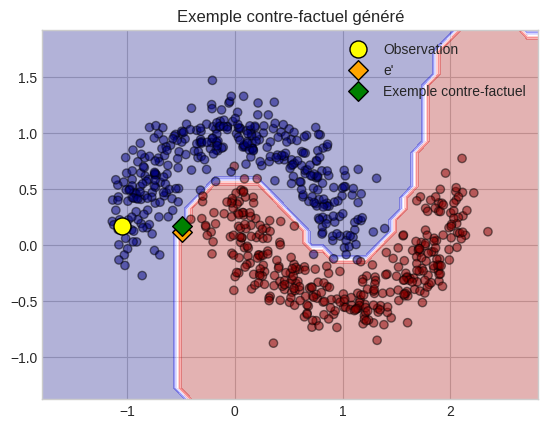

In [105]:
#Test de la fonction
visualisation(clf,x, closest_e,e_opt,'Exemple contre-factuel généré')

## 5. Expérimentations sur données artificielles
Définir un plan d'expérience permettant d'examiner la pertinence des exemples contre-factuels générés


#### a. Stabilité de l'algorithme :
Pour expérimenter la stabilité de l'algorithme nous allons nous intéresser à la variabilité du modèle


- Variabilité du modèle :

Nous allons entrainer plusieurs classifieurs adaptés aux données de type halfMoons (SVM, KNN, RandromForest, Decision Trees et la régression logistique par exemple) sur le même jeu de données d'apprentissage.
L'objectif étant d'évaluer si l'algorithme de génération d'exemples contrefactuels est stable et fonctionne de manière cohérente avec différents modèles.

(L'algorithme doit produire des explications cohérentes indépendamment des modèles utilisés)



Pour cette phase d'expérimentation, nous allons pour chaque modèle, utiliser l'algorithme pour générer des explications sur une donnée de l'ensemble de test.
L'objectif étant de comparer les résultats entre les modèles pour évaluer la stabilité intermodèles

In [106]:
def var_modele(x,eta):
  classifieur = [SVC(kernel ='rbf',C=1.0),KNeighborsClassifier(n_neighbors=3),RandomForestClassifier(max_depth = 4, random_state = 0),tree.DecisionTreeClassifier(max_depth=4),LogisticRegression()]
  for i, c in enumerate(classifieur ):
    print(f"---------- Entrainement modèle {i+1} ----------")
    clf = c.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)
    print(f"Précision du modèle {str(clf)}: {accuracy_score(Y_test, y_pred) * 100}")

    closest_e = GSGeneration(clf,x.reshape(1,-1),eta,n=n)
    e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)


    print(clf.predict(x.reshape(1,-1)))
    print(clf.predict(e_opt.reshape(1,-1)))
    print(f"Observation à interpréter {x} \nPlus proche ennemi issu de l'algorithme 1 {closest_e}\nExemple contre-factuel trouvé{e_opt}")

    title = str(clf)

    visualisation(clf, x, closest_e,e_opt,title)


---------- Entrainement modèle 1 ----------
Précision du modèle SVC(): 97.66666666666667
Meilleur eta trouvé :  0.1
[0]
[1]
Observation à interpréter [0.07607382 1.15350107] 
Plus proche ennemi issu de l'algorithme 1 [0.03050902 0.61221825]
Exemple contre-factuel trouvé[0.07607382 0.61221825]


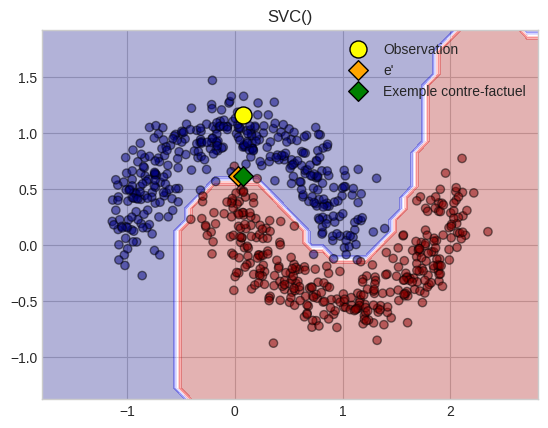

---------- Entrainement modèle 2 ----------
Précision du modèle KNeighborsClassifier(n_neighbors=3): 98.33333333333333
Meilleur eta trouvé :  0.1
[0]
[1]
Observation à interpréter [0.07607382 1.15350107] 
Plus proche ennemi issu de l'algorithme 1 [0.0905288  0.69161451]
Exemple contre-factuel trouvé[0.07607382 0.69161451]


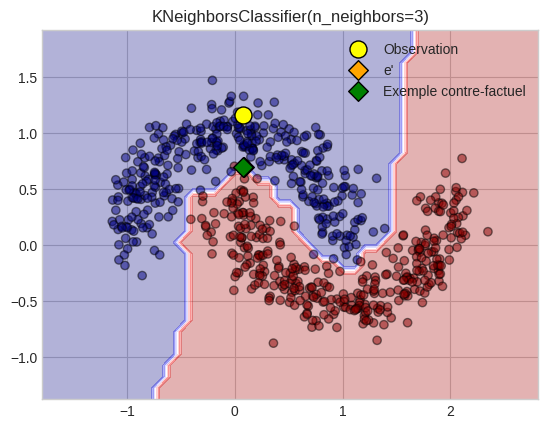

---------- Entrainement modèle 3 ----------
Précision du modèle RandomForestClassifier(max_depth=4, random_state=0): 93.66666666666667
Meilleur eta trouvé :  0.1
[0]
[1]
Observation à interpréter [0.07607382 1.15350107] 
Plus proche ennemi issu de l'algorithme 1 [-0.0077219   0.48057447]
Exemple contre-factuel trouvé[0.07607382 0.48057447]


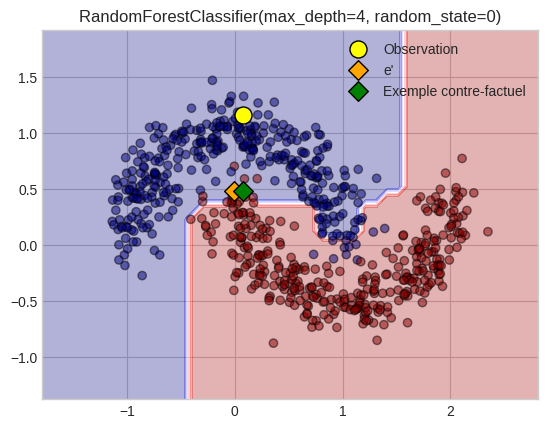

---------- Entrainement modèle 4 ----------
Précision du modèle DecisionTreeClassifier(max_depth=4): 89.66666666666666
Meilleur eta trouvé :  0.1
[0]
[1]
Observation à interpréter [0.07607382 1.15350107] 
Plus proche ennemi issu de l'algorithme 1 [0.0732868  0.37353538]
Exemple contre-factuel trouvé[0.07607382 0.37353538]


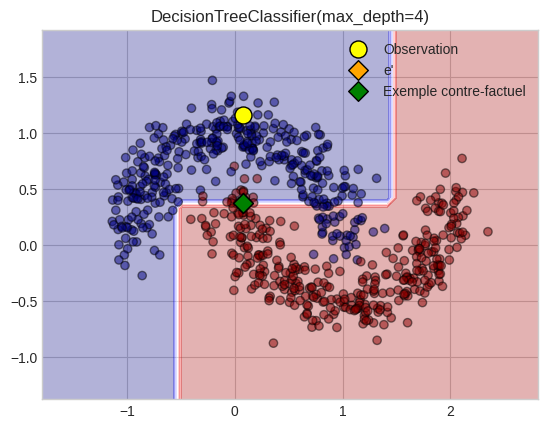

---------- Entrainement modèle 5 ----------
Précision du modèle LogisticRegression(): 85.33333333333334
Meilleur eta trouvé :  0.1
[0]
[1]
Observation à interpréter [0.07607382 1.15350107] 
Plus proche ennemi issu de l'algorithme 1 [0.25885721 0.18370061]
Exemple contre-factuel trouvé[0.25885721 0.18370061]


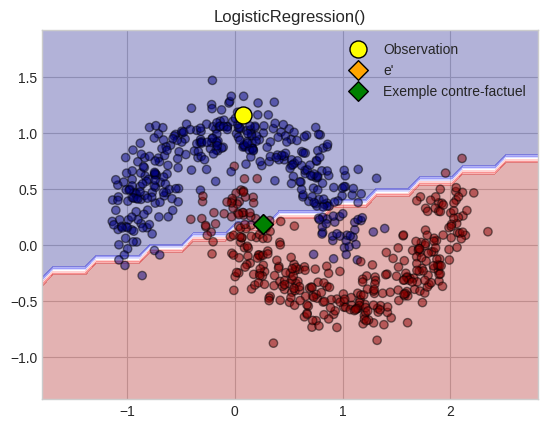

In [107]:
#On sélectionne un point aléatoirement
eta = 0.1 #On choisit un eta
var_modele(X_test[100],eta)

Nous pouvons aisément constater que les contre-factuels diffèrent d'un classifieur à un autre et que tous, n'appartiennent pas à la même classe que la donnée à expliquer x.

Nous disposons donc, de résultats cohérents indépendamment des modèles utilisés, d'où la stabilité intermodèles.

#### b. Variation de la donnée à expliquer :

Nous allons générer dans ce cas, des exemples contrefactuels pour différentes données à expliquer.
Cela permettra de déterminer si les exemples contrefactuels sont cohérents et pertinents pour une variété de cas.


In [108]:
def var_donnee(classifieur, eta):
  #Nous allons générer 5 points de l'ensemble de test qui représenteront l'observation (donnée à expliquer)
  donnees = np.random.randint(X_test.shape[0],size = 5)
  for d in donnees :
    clf = classifieur.fit(X_train,Y_train)
    y_pred = clf.predict(X_test)

    x = X_test[d]
    closest_e = GSGeneration(clf,x.reshape(1,-1),eta,n=n)
    e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)

    title ="Instance n°"+ str(d)
    visualisation(clf, x, closest_e,e_opt,title)

Meilleur eta trouvé :  0.1


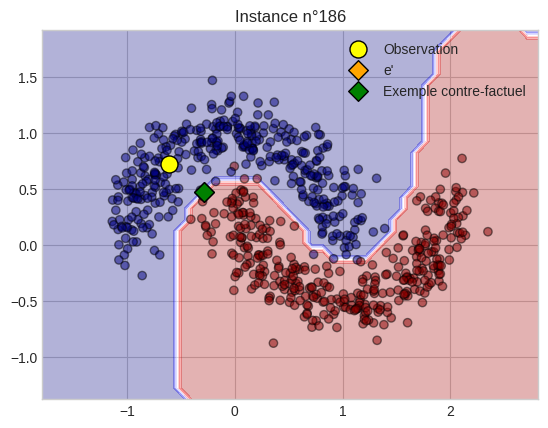

Meilleur eta trouvé :  0.1


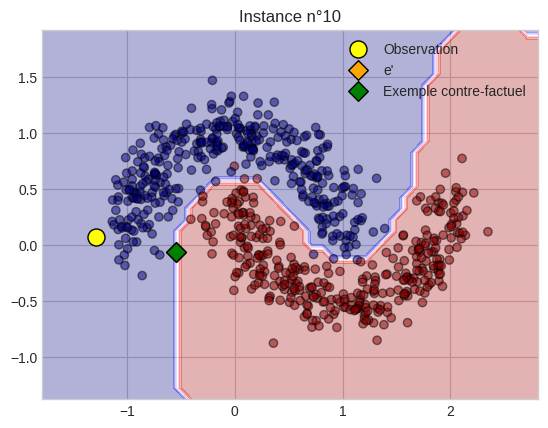

Meilleur eta trouvé :  0.1


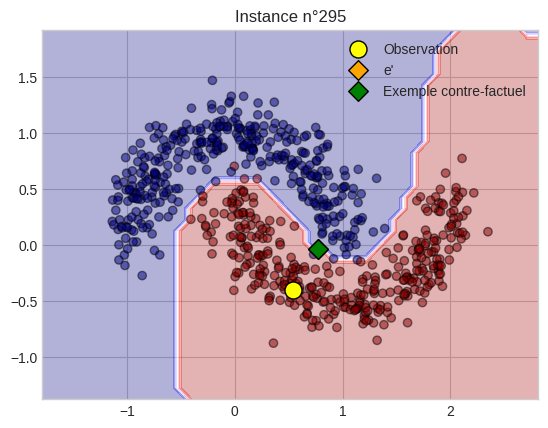

Meilleur eta trouvé :  0.1


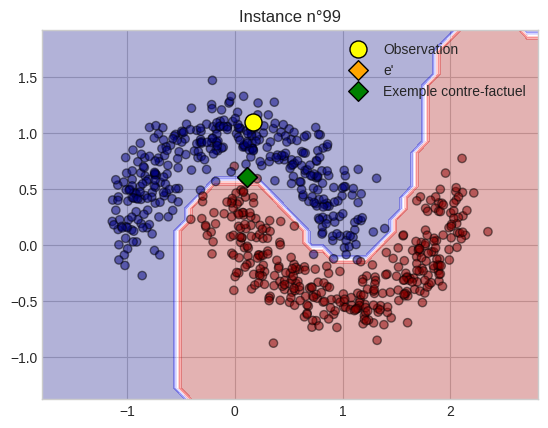

Meilleur eta trouvé :  0.1


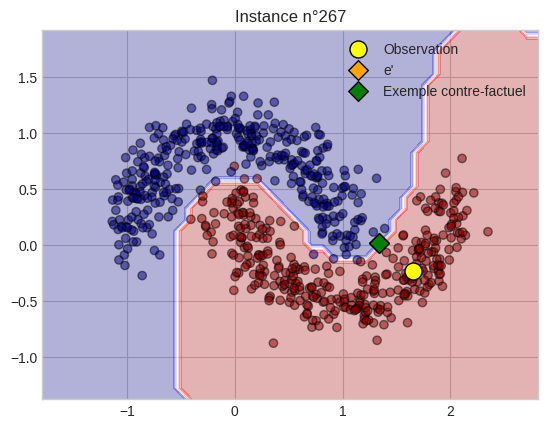

In [109]:
clf = SVC(kernel ='rbf',C=1.0)
var_donnee(clf,0.1)

Nous pouvons constater que le contrefactuel dépend de l'instance, c'est-à-dire de la donnée à expliquer.
Ainsi pour une variété d'observations générées, le contre-factuel associé est toujours cohérent et appartient ainsi à la classe opposée.

A noter que certains contre-factuels sont plus proches de leur observation associée que d'autres. Cela dépend en effet, de la distance de l'observation à la frontière de décision.

#### c. Variation des hyperparamètres de l'algorithme

Pour ce faire, nous allons expérimenter l'effet de la variation des deux hyperparamètres à savoir :
- Le nombre de points à générer n
- Le rayon eta

##### 1. Variation du nombre de points à générer

In [110]:
def var_n(classifieur, x, eta):
  nb_points = [10,100,1000,10000,100000]
  for n in nb_points :
    closest_e = GSGeneration(clf,x.reshape(1,-1),eta,n=n)
    e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)

    title = "Nombre de points générés : "+str(n)

    visualisation(clf, x, closest_e,e_opt,title)

Meilleur eta trouvé :  0.1


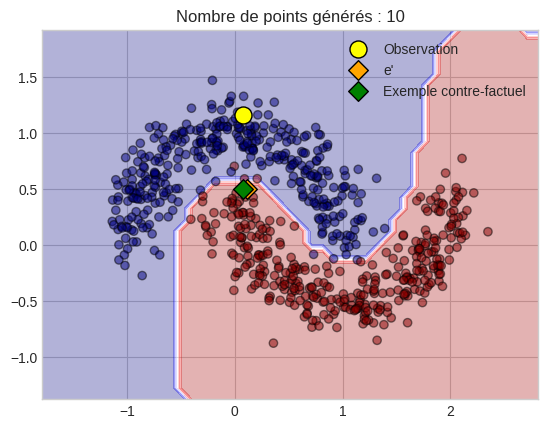

Meilleur eta trouvé :  0.1


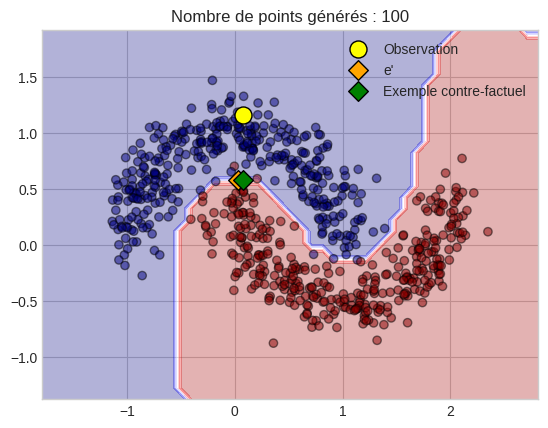

Meilleur eta trouvé :  0.1


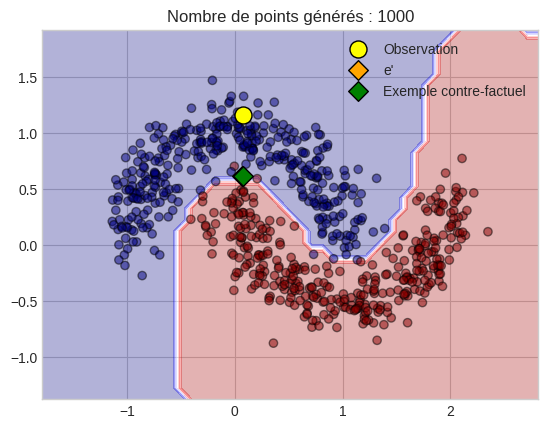

Meilleur eta trouvé :  0.1


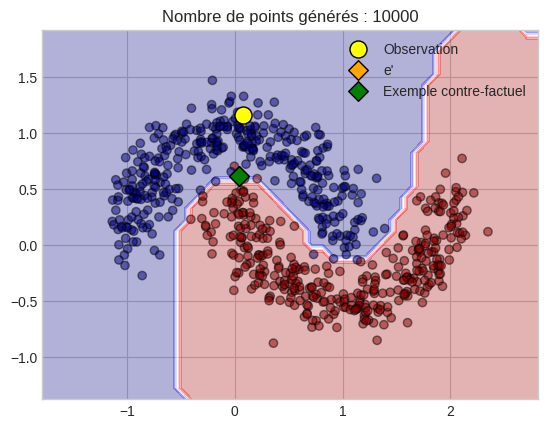

Meilleur eta trouvé :  0.1


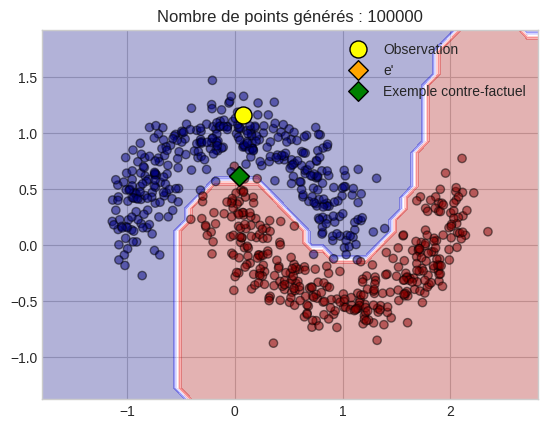

In [111]:
eta = 0.1
clf = SVC(kernel ='rbf',C=1.0)
clf = clf.fit(X_train,Y_train)
var_n(clf, X_test[100],eta)

Nous pouvons voir que la variation du nombre de points générés n'influe pas de façon significative sur le contre-factuel généré.

En effet ce dernier reste plus ou moins similaire


###### 2. Variation du rayon eta


In [112]:
import time

def var_eta(classifieur, x):
  liste_eta = [0.001, 0.01, 0.1, 1, 10,100]
  for eta in liste_eta :
    start_time = time.time()
    closest_e = GSGeneration(clf,x.reshape(1,-1),eta,n=n)
    e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)

    end_time = time.time()

    print("Temps écoulé : ", end_time - start_time)
    title = "Génération avec eta = "+str(eta)

    visualisation(clf, x, closest_e,e_opt,title)


Meilleur eta trouvé :  0.001
Temps écoulé :  4.563932180404663


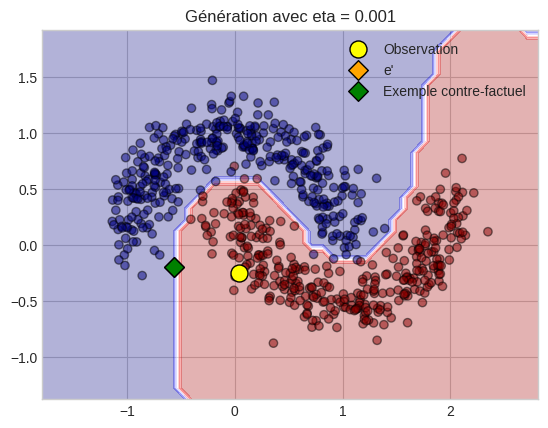

Meilleur eta trouvé :  0.01
Temps écoulé :  0.3508901596069336


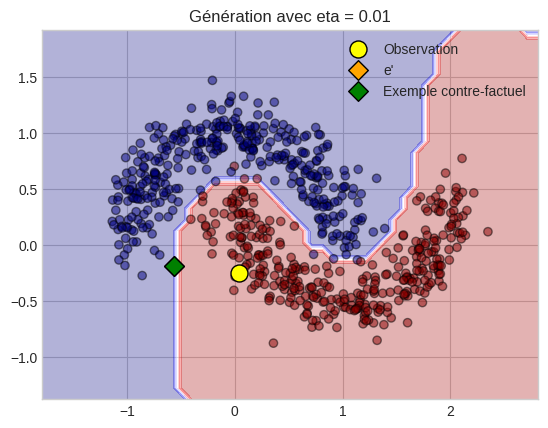

Meilleur eta trouvé :  0.1
Temps écoulé :  0.07963418960571289


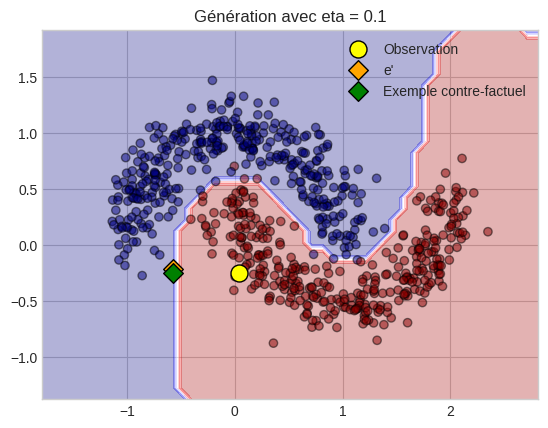

Meilleur eta trouvé :  0.5
Temps écoulé :  0.04633498191833496


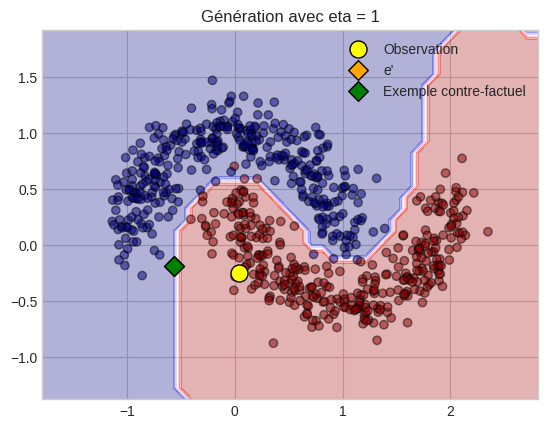

Meilleur eta trouvé :  0.3125
Temps écoulé :  0.07369351387023926


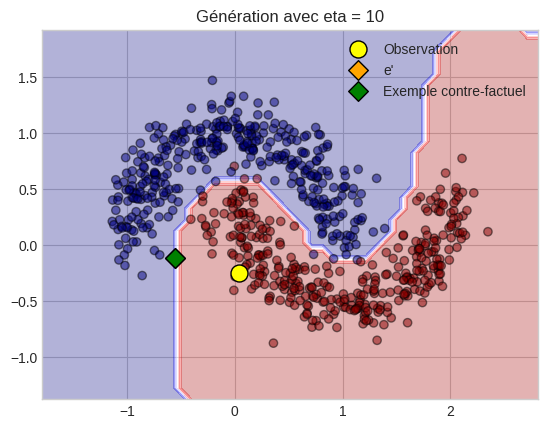

Meilleur eta trouvé :  0.390625
Temps écoulé :  0.11322760581970215


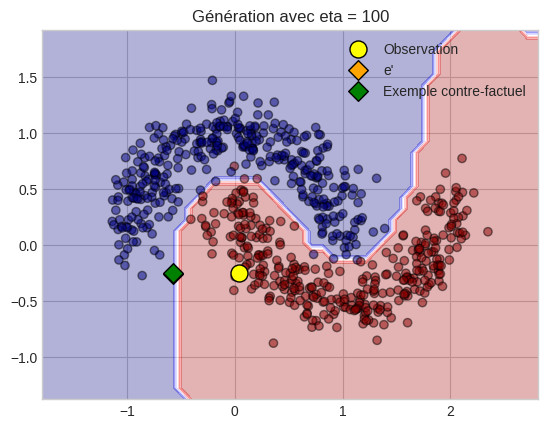

In [113]:
n = 1000
eta = 0.1
clf = SVC(kernel ='rbf',C=1.0)
clf = clf.fit(X_train,Y_train)
var_eta(clf, X_train[100])

Nous pouvons constater que la variation de l'hyperparamètre eta n'apporte pas de modification significative (visuellement parlant).
Toutefois, nous remarquons que le temps d'exécution augmente proportionnellement à l'augementation du paramètre eta.

## 6. Expérimentations sur données classiques

Nous allons mener notre expérimentation sur le jeu de données **load_breast_cancer**

In [7]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

bc = load_breast_cancer()
#Visualisation du dataset
df = pd.DataFrame(bc.data, columns = bc.feature_names)
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [8]:
df['Labels'] = bc.target
df

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Labels
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [9]:
#Définir nos données
X,Y = bc.data, bc.target

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state=42)

In [10]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((398, 30), (171, 30), (398,), (171,))

In [11]:
#Classifieur :
clf = KNeighborsClassifier(n_neighbors=3).fit(X_train, Y_train)

y_pred = clf.predict(X_test)
print("Précision du modèle KNN : {:.2f}%".format(accuracy_score(Y_test, y_pred) * 100))

Précision du modèle KNN : 94.15%


In [12]:
x = X_test[50]
n = 1000
eta = 0.1

closest_e = GSGeneration(clf,x.reshape(1,-1),eta,n=n)
e_opt = GSFeatureSelection(clf,x.reshape(1,-1),closest_e)

print(e_opt)

Meilleur eta trouvé :  0.1
[ 1.71900000e+01  2.20700000e+01  1.78803159e+02  1.01182665e+03
 -7.24547777e+01 -1.12745962e+02  9.06100000e-02  6.52700000e-02
  1.86700000e-01  5.58000000e-02  9.17722387e+01  7.38300000e-01
  2.81900000e+00 -1.97601440e+01  9.34469286e+01 -1.00276044e+02
  1.40990875e+02 -8.56805037e+01  1.14400000e-02  1.57500000e-03
  2.15800000e+01 -1.17062296e+02  2.62213759e+01  1.08777073e+03
  1.55800000e-01  2.56700000e-01 -8.62769969e+01  1.98400000e-01
  3.21600000e-01  7.57000000e-02]


Le temps d'execution augmente considérablement dans ce cas étant donné la nature complexe des données.

In [13]:
print(e_opt)

[ 1.71900000e+01  2.20700000e+01  1.78803159e+02  1.01182665e+03
 -7.24547777e+01 -1.12745962e+02  9.06100000e-02  6.52700000e-02
  1.86700000e-01  5.58000000e-02  9.17722387e+01  7.38300000e-01
  2.81900000e+00 -1.97601440e+01  9.34469286e+01 -1.00276044e+02
  1.40990875e+02 -8.56805037e+01  1.14400000e-02  1.57500000e-03
  2.15800000e+01 -1.17062296e+02  2.62213759e+01  1.08777073e+03
  1.55800000e-01  2.56700000e-01 -8.62769969e+01  1.98400000e-01
  3.21600000e-01  7.57000000e-02]


In [14]:
print(x)

[1.719e+01 2.207e+01 1.116e+02 9.283e+02 9.726e-02 8.995e-02 9.061e-02
 6.527e-02 1.867e-01 5.580e-02 4.203e-01 7.383e-01 2.819e+00 4.542e+01
 4.493e-03 1.206e-02 2.048e-02 9.875e-03 1.144e-02 1.575e-03 2.158e+01
 2.933e+01 1.405e+02 1.436e+03 1.558e-01 2.567e-01 3.889e-01 1.984e-01
 3.216e-01 7.570e-02]


In [16]:
print(clf.predict(x.reshape(1,-1)))
print(clf.predict(e_opt.reshape(1,-1)))

[0]
[1]


Nous pouvons constater que la donnée à expliquer et l'exemple contre-factuel généré n'appartiennent pas à la même classe.


Tentons à présent, d'identifier les différences entre les deux, autrement dit, l'explication

In [19]:
np.allclose(x,e_opt) #Les deux vecteurs sont donc différents

False

In [20]:
np.where(x == e_opt)

(array([ 0,  1,  6,  7,  8,  9, 11, 12, 18, 19, 20, 24, 25, 27, 28, 29]),)

In [23]:
df.columns[2], df.columns[10]

('mean perimeter', 'radius error')

Nous pouvons constater que l'exemple de contre-factuel généré est relativement proche de la donnée x que nous cherchons à expliquer, tout en appartenant à une classe opposée.

Ainsi, la modification de certains attributs, tels que l'attribut 2 correspondant au périmètre moyen ou l'attribut 10 correspondant à l'erreur de diamètre, explique pourquoi le modèle a prédit cette classe plutôt qu'une autre.

En d'autres termes, une variation du périmètre moyen ou de l'erreur de calcul du diamètre peut expliquer la classification.